In [1]:
%load_ext autoreload
%autoreload 2

# Preparations

In [2]:
import mkl
mkl.set_num_threads(1)

testing = True # TODO: run in testing mode (fast)

In [ ]:
# Need to run these scripts once in the beginning to prepare all ingredients for the analysis
# - this might take several minutes, so run these only if you haven't done so before.

if not testing:
    # load IceCube's effective area and rotate it to approximate other detectors
    %run ../../core/aeff_calculations.py

    # calculate the atmospheric neutrino background using MCEq (IceCube-centric)
    %run ../../core/atmospheric_background.py

    # run these every time there are updates to resolution, binning, or mephistograms
    # load and prepare the energy and angular resolutions
    %run ../../core/resolution.py

    # gather all ingredients and save them as unified 'mephistogram' data structure
    %run ../../core/prepare_histograms.py

# Imports

In [3]:
import pickle
from collections import namedtuple
from itertools import product
from copy import copy
from os.path import join

import numpy as np
import pandas as pd
import seaborn as sns

plt = sns.mpl.pyplot
from aeff_calculations import calc_aeff_factor
from fluxes import (
    astro_flux,
    atmo_background,
    cut_off,
    power_law,
)
import mephisto
from scipy.optimize import fmin_l_bfgs_b
from scipy.interpolate import InterpolatedUnivariateSpline

from scipy.stats import chi2, norm
from settings import LOCALPATH, BASEPATH, sigma3, sigma5, PHI_NGC, GAMMA_NGC, E0_NGC, LIVETIME
import settings as st
from likelihood import setup_multi_llh, ps_llh_multi
from tools import (
    array_source_interp,
    get_scaler,
    scaling_estimation,
)
from fluxes import PL_flux, PLcut_flux
from tqdm import tqdm

Could not import healpy.
functions plot_area, add_catalog, and add_extended_plane will not work.


# Settings

In [4]:
# energy resolution files
e_res_files = {
    "baseline": join(LOCALPATH, "energy_smearing_GP_up.pckl"),
    "reproduction": join(LOCALPATH, "artificial_smoothed_energy_smearing_GP_up.pckl"),
    "1:1": join(LOCALPATH, "idealized_artificial_energy_smearing_GP_up.pckl"),
    "improved-20": join(
        LOCALPATH, "improved_0.2_artificial_energy_smearing_GP_up.pckl"
    ),
    "improved-50": join(
        LOCALPATH, "improved_0.5_artificial_energy_smearing_GP_up.pckl"
    ),
}

# plot settings for different detector_configurations
det_plotting = {
    "IceCube": {
        "color": "k",
        "ls": "-",
        "label": "IceCube",
        "plainlabel": "IceCube",
        "marker": "d",
    },
    "P-ONE": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + IC-North",
        "plainlabel": "P-ONE",
        "marker": "v",
    },
    "KM3NeT": {
        "color": "#66cccc",
        "ls": "--",
        "label": "IC + KM3NeT",
        "plainlabel": "KM3NeT",
        "marker": "v",
    },
    "Plenum-1": {
        "color": "#339999",
        "ls": "-",
        "label": r"IC + PLE$\nu$M-1",
        "plainlabel": r"PLE$\nu$M-1",
        "marker": "s",
    },
    "Plenum-2": {
        "color": "#a50000",
        "ls": "-.",
        "label": r"IC + PLE$\nu$M-2",
        "plainlabel": r"PLE$\nu$M-2",
        "marker": "o",
    },
}

# Effective area

We use here only upgoing events with dec>-5deg, since this is the threshold for a pure data set with few muons.

In [5]:
with open(join(LOCALPATH, "effective_area_MH_upgoing.pckl"), "rb") as f:
    aeff_2d = pickle.load(f)
# print(aeff_2d.keys())
# print(aeff_2d["IceCube"])

# Atmospheric background
Actually, we would need to account for the different zenith regions of a source, if the detector is not at one of the poles.
This is currently not yet implemented

In [6]:
with open(join(LOCALPATH, "atmospheric_background_daemonflux_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# check if histos are matching
print(bckg_histo["IceCube"].match(aeff_2d["IceCube"], verbose=True))

Elementary arithmetic possible.
True


# Energy resolution function

In [7]:
# baseline resolution
with open(e_res_files["baseline"], "rb") as f:
    baseline_eres = pickle.load(f)
baseline_eres.normalize(axis=1)  # normalize per logE_true

# resolution improved by 50%
with open(e_res_files["improved-50"], "rb") as f:
    improved_eres = pickle.load(f)
improved_eres.normalize(axis=1)  # normalize per logE_true

# checking if matrix multiplication is possible
print(aeff_2d["IceCube"].match_matmul(baseline_eres, verbose=True))
# ... it's not commutative, though
print(baseline_eres.match_matmul(aeff_2d["IceCube"], verbose=True, raise_err=False))
energy_reso = {"baseline": baseline_eres, "improved": improved_eres} # easy access

Matrix multiplication possible.
True
Matrix multiplication not possible. Shapes are (140, 139) and (100, 140);
False


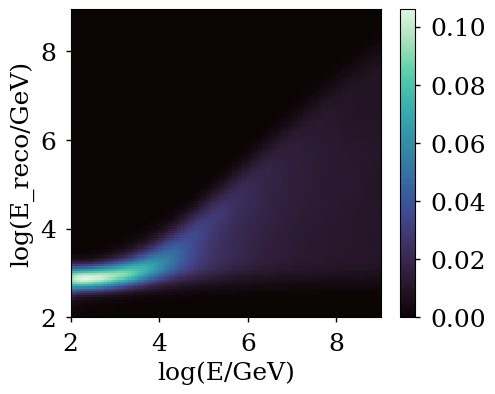

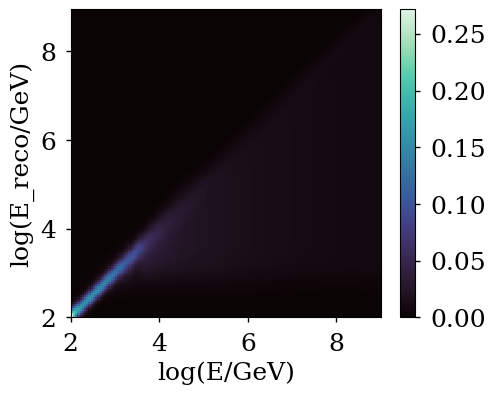

In [8]:
# full range, easy plotting
baseline_eres.plot()
improved_eres.plot()

Text(0.5, 1.0, 'Baseline energy resolution')

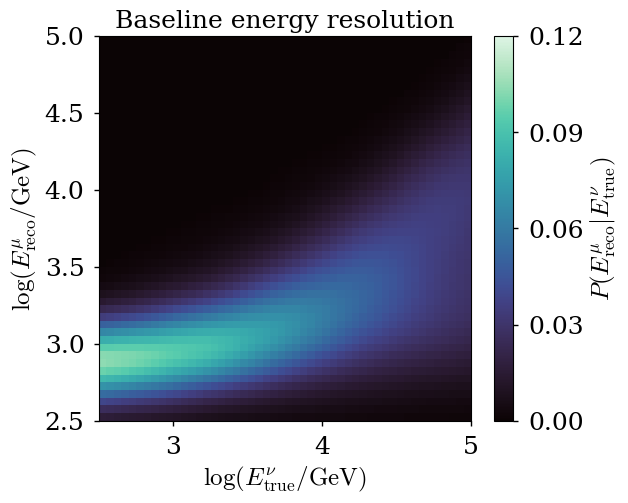

In [9]:
# nice plot
ebounds = (2.5, 5)

f, ax = plt.subplots(figsize=(6, 5))
f, ax = mephisto.plot_mephistogram(baseline_eres, f=f, ax=ax, vmin=0, vmax=0.12,
    linewidth=0,
    rasterized=True,)
ax.set_xlabel("")
ax.set_xlim(*ebounds)
ax.set_ylim(*ebounds)
ax.set_ylabel(r"$\log(E^{\mu}_{\rm reco}/{\rm GeV})$")
ax.set_xlabel(r"$\log(E^{\nu}_{\rm true}/{\rm GeV})$")
ax.collections[0].colorbar.set_label(r"$P(E^{\mu}_{\rm reco}|E^{\nu}_{\rm true})$")
ax.collections[0].colorbar.set_ticks(np.arange(0, 0.13, step=0.03))
ax.set_title("Baseline energy resolution")

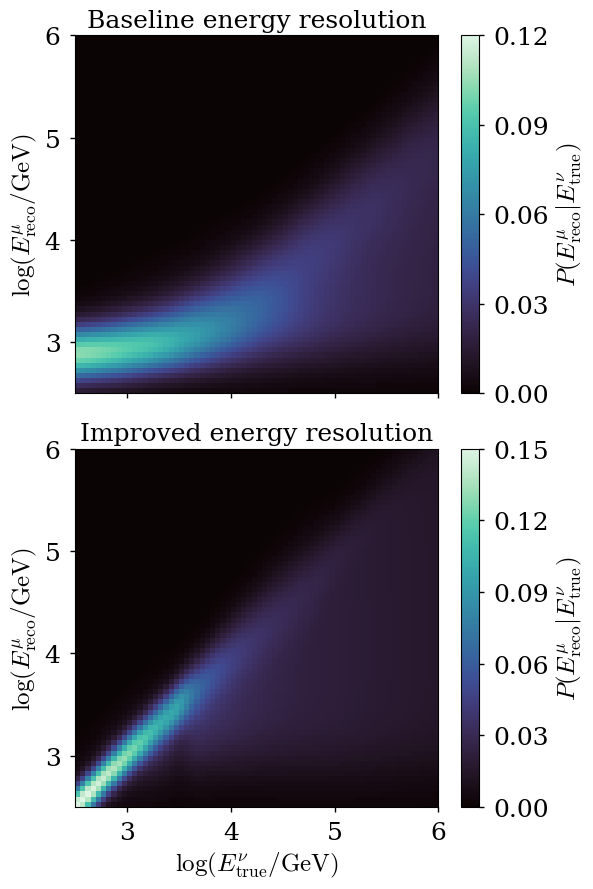

In [10]:
# nice plot
ebounds = (2.5, 6)
ticks = np.arange(3, 7)
f, axes = plt.subplots(nrows=2, figsize=(6, 9), sharex=True)
f, ax = mephisto.plot_mephistogram(baseline_eres, f=f, ax=axes[0], vmin=0, vmax=0.12,
    linewidth=0,
    rasterized=True,)
ax.set_xlabel("")
ax.set_xlim(*ebounds)
ax.set_ylim(*ebounds)
ax.set_ylabel(r"$\log(E^{\mu}_{\rm reco}/{\rm GeV})$")
ax.collections[0].colorbar.set_label(r"$P(E^{\mu}_{\rm reco}|E^{\nu}_{\rm true})$")
ax.collections[0].colorbar.set_ticks(np.arange(0, 0.13, step=0.03))
ax.set_title("Baseline energy resolution")
ax.set_yticks(ticks)

f, ax = mephisto.plot_mephistogram(improved_eres, f=f, ax=axes[1], vmin=0, vmax=0.15,
    linewidth=0,
    rasterized=True,)
ax.set_xlim(*ebounds)
ax.set_ylim(*ebounds)
ax.set_ylabel(r"$\log(E^{\mu}_{\rm reco}/{\rm GeV})$")
ax.set_xlabel(r"$\log(E^{\nu}_{\rm true}/{\rm GeV})$")
cb = ax.collections[0].colorbar
cb.set_label(r"$P(E^{\mu}_{\rm reco}|E^{\nu}_{\rm true})$")
cb.set_ticks(np.arange(0, 0.16, step=0.03))
ax.set_title("Improved energy resolution")
ax.set_yticks(ticks)

f.tight_layout()
f.savefig(join(BASEPATH, "plots/ngc_paper/energy_resolution_comparison.pdf"))

# Psi²-Energy resolution

NOTE: psi changes per detector over the day. For the sake of (optimistic) simplicity, we choose the horizontal resolution for all detectors

In [11]:
# angular resolution
with open(join(LOCALPATH, f"Psi2-{st.delta_psi_max}_res_mephistograms.pckl"), "rb") as f:
    all_psi = pickle.load(f)
e_psi2_grid = all_psi["dec-0.0"]
e_psi2_grid.normalize()

# uniform, normalized background grid
bckg_psi2_grid = mephisto.like(e_psi2_grid, fill_value=1)
bckg_psi2_grid.normalize()

Text(0.5, 0, '$\\Psi^2 = |\\Omega_{\\rm true} - \\Omega_{\\rm reco}|^2$')

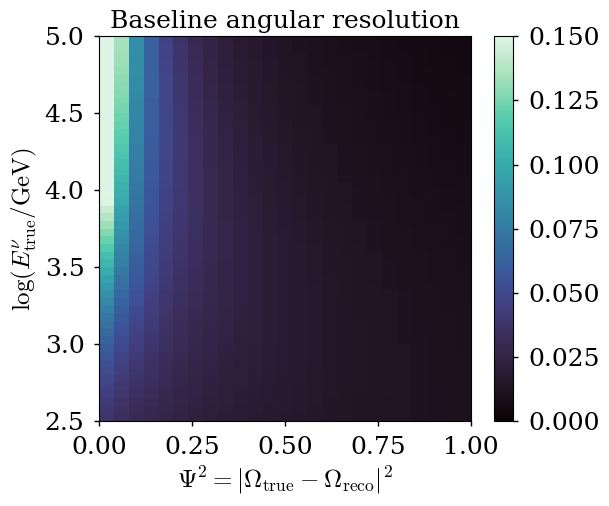

In [12]:

f, ax = plt.subplots(figsize=(6, 5))
ax.set_title("Baseline angular resolution")
f, ax = mephisto.plot_mephistogram(
    e_psi2_grid,
    f=f,
    ax=ax,  vmin=0, vmax=0.15,
    linewidth=0,
    rasterized=True, #norm=LogNorm()
)
ax.set_ylim(2.5, 5)
ax.set_xlim(0, 1)
ax.set_ylabel(r"$\log(E^{\nu}_{\rm true}/{\rm GeV})$")
ax.set_xlabel(r"$\Psi^2 = |\Omega_{\rm true} - \Omega_{\rm reco}|^2$")

# NGC1068 source parameters

In [13]:
# ngc flux error contour
gamma_c_68, phi_c_68 = np.loadtxt(join(LOCALPATH, "ngc_paper_68_contour.txt"))
phi_c_68 /= 1e11
gamma_c_68_prev, phi_c_68_prev = np.loadtxt(
    join(LOCALPATH, "tenyr_paper_68_contour.txt")
)

ngc_flux = PL_flux(PHI_NGC, GAMMA_NGC, E0_NGC, "powerlaw")

In [14]:
import settings as st
st.PHI_NGC

5e-14

In [15]:
# generic source config without dec coordinate
src_config = dict(
    sindec_mids=st.sindec_mids,
    livetime=LIVETIME,
    ewidth=st.ewidth,
    dpsi_max=0,
    grid_2d=e_psi2_grid,
)
# generic bg config
bg_config = copy(src_config)
bg_config["dpsi_max"] = st.delta_psi_max
bg_config["grid_2d"] = bckg_psi2_grid

# ... with ngc declination
ngc_src_config = copy(src_config)
ngc_src_config["dec"] = st.ngc1068.dec.rad
ngc_bg_config = copy(bg_config)
ngc_bg_config["dec"] = st.ngc1068.dec.rad

## Check event numbers

In [16]:
ident = "IceCube"
# check that the bins match
assert (aeff_2d[ident].bins[1] == ngc_src_config["grid_2d"].bins[1]).all()
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

k_s = astro_flux(
    aeff_factor_signal,
    10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=ngc_flux,
)
print("ngc 1068:", np.sum(k_s))  # ~85

ngc 1068: 88.11995358931374


## PL+Cut: source parameters

In [17]:
# cutoff parameters
# see energy_spectrum_wiggle.ipynb for 'optimization'
# of these parameters
print(st.Gamma_cut, st.logE_cut)  # log10 (Ecut / GeV)

tmp_flux = PLcut_flux(PHI_NGC, st.Gamma_cut, st.logE_cut, E0_NGC, "powerlaw with cutoff")

2.0 3.5



### scale the fluxes such that the event numbers match


In [18]:
## event numbers for IceCube based on NGC 1068 flux
ident = "IceCube"
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)
astro_ev_sum_pl = np.sum(
    astro_flux(
        aeff_factor_signal,
        10 ** aeff_factor_signal.bin_mids[1],
        baseline_eres,
        1,
        ngc_flux,
    )
)
print("IceCube expected number of events:", astro_ev_sum_pl)  # see above
# cutoff
astro_ev_sum_cut = np.sum(
    astro_flux(
        aeff_factor_signal,
        10 ** aeff_factor_signal.bin_mids[1],
        baseline_eres,
        1,
        tmp_flux,
    )
)
# calculate the flux normalization so that event numbers match für IceCube
flux_scaling_cut = astro_ev_sum_pl / astro_ev_sum_cut
print("Need to scale the PL+cutoff flux by:", flux_scaling_cut, "(flux_scaling_cut)")
print("flux normalization before", PHI_NGC, "after", PHI_NGC * flux_scaling_cut)

# define the correctly normalized PL+cut flux for NGC 1068
ngc_cut_flux = PLcut_flux(
    PHI_NGC * flux_scaling_cut,
    st.Gamma_cut,
    st.logE_cut,
    E0_NGC,
    "powerlaw with cutoff",
)

IceCube expected number of events: 88.11995358931374
Need to scale the PL+cutoff flux by: 1.4514517646437384 (flux_scaling_cut)
flux normalization before 5e-14 after 7.257258823218692e-14


### Plot 1D analysis slice histograms

In [20]:
if False:    
    local_background_flux = array_source_interp(
        ngc_src_config["dec"],
        bckg_histo["IceCube"],
        bckg_histo["IceCube"].bin_mids[0],
        axis=1,
    )
    np.savetxt(join(BASEPATH, "resources/local_background_ngc.txt"), local_background_flux)
    ident = "IceCube"
    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

    for eres, e_name in zip([baseline_eres, improved_eres], ["baseline", "improved"]):
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(
                ngc_src_config["dec"],
                bckg_histo["IceCube"],
                bckg_histo["IceCube"].bin_mids[0],
                axis=1,
            ),
            energy_resolution=eres,
        )


        # power law
        k_s_pl = astro_flux(
            aeff_factor_signal,
            10 ** aeff_factor_signal.bin_mids[1],
            eres,
            1,
            ngc_flux,
        )

        # cutoff
        k_s_cut = astro_flux(
            aeff_factor_signal,
            10 ** aeff_factor_signal.bin_mids[1],
            eres,
            1,
            ngc_cut_flux,
        )
        np.savetxt(join(BASEPATH, f"resources/background_events_{e_name}.txt"), k_b)
        np.savetxt(join(BASEPATH, f"resources/PL_events_{e_name}.txt"), k_s_pl)
        np.savetxt(join(BASEPATH, f"resources/PLC_events_{e_name}.txt"), k_s_cut)

# source $\nu_\mu$ : 88.1
# atmo. $\nu_\mu$ : 1311.2 (within 28 deg²)
# source $\nu_\mu$ : 88.1
# atmo. $\nu_\mu$ : 1311.2 (within 28 deg²)


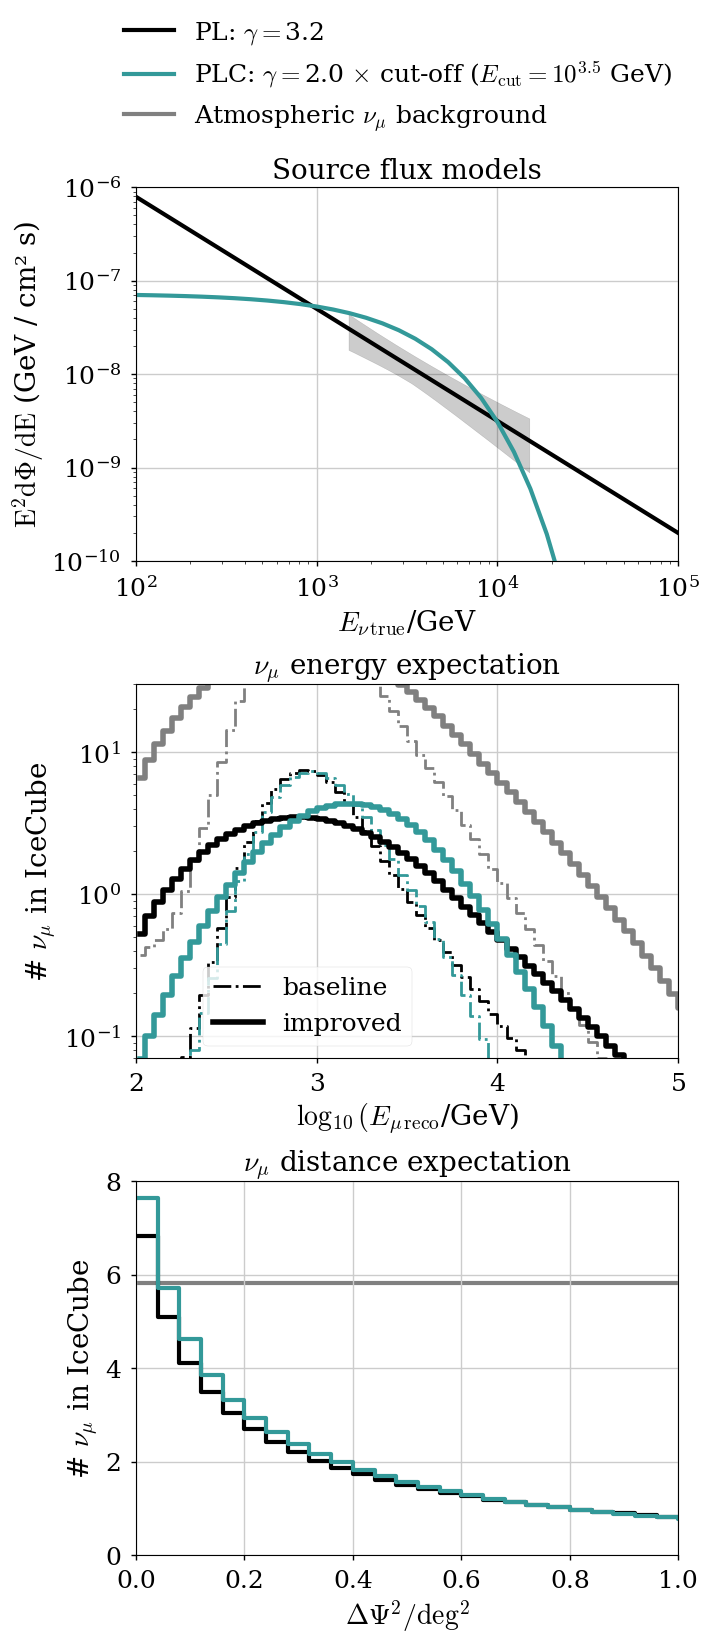

In [21]:
sq_deg = np.pi * st.delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)
cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

f, axes = plt.subplots(nrows=3, figsize=(7, 19))
ax = axes[0]
fontsize = 20
ax.set_title("Source flux models", fontsize=fontsize)

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
# without energy range interval
# x_cont = np.logspace(1.9, 5.1, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, E0_NGC, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    color="k",
    alpha=0.2,
)

ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"PL: $\gamma=${GAMMA_NGC}",
    color="k",
    alpha=1,
    lw=3,
)

ax.plot(
    x_evals,
    cut * (x_evals**y_scaling),
    label=rf"PLC: $\gamma=${st.Gamma_cut} $\times$ "
    + rf"cut-off ($E_{{\rm cut}}=10^{{{st.logE_cut:1.1f}}}$ GeV)",
    color="#339999",
    lw=3,
)
ax.plot(
    10 ** aeff_factor_signal.bin_mids[1],
    array_source_interp(
        ngc_src_config["dec"],
        bckg_histo["IceCube"],
        bckg_histo["IceCube"].bin_mids[0],
        axis=1,
    )
    * sq_deg
    * (10 ** aeff_factor_signal.bin_mids[1] ** y_scaling),
    label=r"Atmospheric $\nu_\mu$ background",
    color="gray",
    lw=3,
)

ax.set_yscale("log")
ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)", fontsize=fontsize)
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV", fontsize=fontsize)
ax.set_ylim(1e-10, 1e-6)
ax.set_xlim(1e2, 1e5)
f.legend(
    loc="upper center",
    frameon=False,
    bbox_to_anchor=(0.5, 0.93),
)


### plot Event numbers in E_reco
ii = 0
evals = baseline_eres.bin_mids[1]
ax = axes[1]
ident = "IceCube"
aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

for eres, e_name in zip([baseline_eres, improved_eres], ["baseline", "improved"]):
    k_b = atmo_background(
        aeff_factor_bckg,
        array_source_interp(
            ngc_src_config["dec"],
            bckg_histo["IceCube"],
            bckg_histo["IceCube"].bin_mids[0],
            axis=1,
        ),
        energy_resolution=eres,
    )

    # power law
    k_s_pl = astro_flux(
        aeff_factor_signal,
        10 ** aeff_factor_signal.bin_mids[1],
        eres,
        1,
        ngc_flux,
    )

    # cutoff
    k_s_cut = astro_flux(
        aeff_factor_signal,
        10 ** aeff_factor_signal.bin_mids[1],
        eres,
        1,
        ngc_cut_flux,
    )

    ax = axes[1]
    ax.plot(
        evals,
        k_s_pl.sum(axis=0),
        drawstyle="steps-mid",
        label=e_name,
        color="k",
        lw=4 if e_name == "improved" else 2,
        ls="-" if e_name == "improved" else "-.",
    )

    ax.plot(
        evals,
        k_s_cut.sum(axis=0),
        drawstyle="steps-mid",
        color="#339999",
        lw=4 if e_name == "improved" else 2,
        ls="-" if e_name == "improved" else "-.",
    )

    ax.plot(
        evals,
        k_b.sum(axis=0),
        drawstyle="steps-mid",
        color="gray",
        lw=4 if e_name == "improved" else 2,
        ls="-" if e_name == "improved" else "-.",
    )
    print(rf"# source $\nu_\mu$ : {np.sum(k_s_pl):1.1f}")
    print(rf"# atmo. $\nu_\mu$ : {np.sum(k_b):1.1f} (within {sq_deg:1.0f} deg²)")
ax.set_title(r"$\nu_\mu$ energy expectation", fontsize=fontsize)
ax.set_yscale("log")
ax.set_xlim(2, 5)
ax.set_ylim(7e-2, 3e1)
ax.set_xlabel(r"$\log_{10}(E_{\mu \, \rm reco}$/GeV)", fontsize=fontsize)
ax.set_ylabel(r"# $\nu_\mu$ in IceCube", fontsize=fontsize)
ax.legend(loc=3, bbox_to_anchor=(0.1, 0.0))
ax.set_xticks([2, 3, 4, 5])

ax = axes[2]
ax.plot(
    np.concatenate([[-0.1], st.psi2_mids]),
    np.concatenate([[0], k_s_pl.sum(axis=1)]),
    drawstyle="steps-mid",
    color="k",
    lw=3,
)

ax.plot(
    np.concatenate([[-0.1], st.psi2_mids]),
    np.concatenate([[0], k_s_cut.sum(axis=1)]),
    drawstyle="steps-mid",
    color="#339999",
    lw=3,
)

ax.plot(
    np.concatenate([[-0.1], st.psi2_mids]),
    np.concatenate([[0], k_b.sum(axis=1)]),
    drawstyle="steps-mid",
    color="gray",
    lw=3,
    zorder=0,
)

ax.set_ylabel(r"# $\nu_\mu$ in IceCube", fontsize=fontsize)
ax.set_xlim(0, 1)
ax.set_ylim(0, 8)
ax.set_xlabel(r"$\Delta \Psi ^2 / {\rm deg}^2$", fontsize=fontsize)
ax.set_title(r"$\nu_\mu$ distance expectation", fontsize=fontsize)
f.subplots_adjust(hspace=0.33, top=0.83)

f.savefig(
    join(BASEPATH, f"plots/ngc_paper/ngc_spectral_improved_dpsi.pdf"),
    bbox_inches="tight",
)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


# source $\nu_\mu$ : 88.1
# atmo. $\nu_\mu$ : 1311.2 (within 28 deg²)


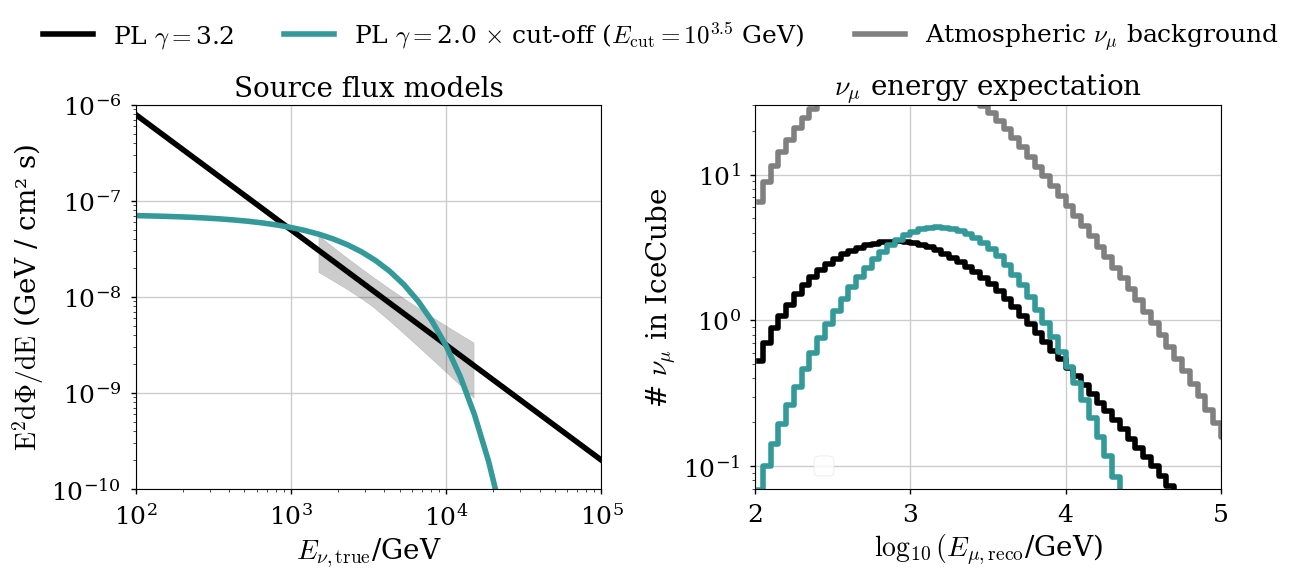

In [24]:
if False:
    sq_deg = np.pi * st.delta_psi_max**2
    x_evals = np.logspace(0, 9, 100)
    y_scaling = 2

    pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)
    cut = power_law(
        x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
    ) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

    f, axes = plt.subplots(ncols=2, figsize=(14, 6))
    ax = axes[0]
    fontsize = 20
    ax.set_title("Source flux models", fontsize=fontsize)

    # error contour
    # with energy range interval
    x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
    # without energy range interval
    # x_cont = np.logspace(1.9, 5.1, 100)
    c_low = np.zeros_like(x_cont)
    c_high = np.zeros_like(x_cont)
    for ii, xe in enumerate(x_cont):
        tmp = power_law(xe, E0_NGC, gamma_c_68, phi_c_68 / 1e3)
        c_low[ii] = np.min(tmp)
        c_high[ii] = np.max(tmp)
    ax.fill_between(
        x_cont,
        c_low * (x_cont**y_scaling),
        c_high * (x_cont**y_scaling),
        color="k",
        alpha=0.2,
    )

    ax.plot(
        x_evals,
        pl * (x_evals**y_scaling),
        label=rf"PL: $\gamma=${GAMMA_NGC}",
        color="k",
        alpha=1,
        lw=4,
    )

    ax.plot(
        x_evals,
        cut * (x_evals**y_scaling),
        label=rf"PLC: $\gamma=${st.Gamma_cut} $\times$ "
        + rf"cut-off ($E_{{\rm cut}}=10^{{{st.logE_cut:1.1f}}}$ GeV)",
        color="#339999",
        lw=4,
    )
    ax.plot(
        10 ** aeff_factor_signal.bin_mids[1],
        array_source_interp(
            ngc_src_config["dec"],
            bckg_histo["IceCube"],
            bckg_histo["IceCube"].bin_mids[0],
            axis=1,
        )
        * sq_deg
        * (10 ** aeff_factor_signal.bin_mids[1] ** y_scaling),
        label=r"Atmospheric $\nu_\mu$ background",
        color="gray",
        lw=4,
    )

    ax.set_yscale("log")
    ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)", fontsize=fontsize)
    ax.set_xscale("log")
    ax.set_xlabel(r"$E_{\nu, \rm true}$/GeV", fontsize=fontsize)
    ax.set_ylim(1e-10, 1e-6)
    ax.set_xlim(1e2, 1e5)
    f.legend(
        loc="upper center",
        frameon=False,
        ncols=3,
        bbox_to_anchor=(0.5, 0.93),
    )


    ### plot Event numbers in E_reco
    ii = 0
    evals = baseline_eres.bin_mids[1]
    ax = axes[1]
    ident = "IceCube"
    aeff_factor_bckg = calc_aeff_factor(aeff_2d[ident], **ngc_bg_config)
    aeff_factor_signal = calc_aeff_factor(aeff_2d[ident], **ngc_src_config)

    for eres, e_name in zip([improved_eres], ["improved"]):
        k_b = atmo_background(
            aeff_factor_bckg,
            array_source_interp(
                ngc_src_config["dec"],
                bckg_histo["IceCube"],
                bckg_histo["IceCube"].bin_mids[0],
                axis=1,
            ),
            energy_resolution=eres,
        )

        # power law
        k_s_pl = astro_flux(
            aeff_factor_signal,
            10 ** aeff_factor_signal.bin_mids[1],
            eres,
            1,
            ngc_flux,
        )

        # cutoff
        k_s_cut = astro_flux(
            aeff_factor_signal,
            10 ** aeff_factor_signal.bin_mids[1],
            eres,
            1,
            ngc_cut_flux,
        )

        ax = axes[1]
        ax.plot(
            evals,
            k_s_pl.sum(axis=0),
            drawstyle="steps-mid",
            # label=e_name,
            color="k",
            lw=4 if e_name == "improved" else 2,
            ls="-" if e_name == "improved" else "-.",
        )

        ax.plot(
            evals,
            k_s_cut.sum(axis=0),
            drawstyle="steps-mid",
            color="#339999",
            lw=4 if e_name == "improved" else 2,
            ls="-" if e_name == "improved" else "-.",
        )

        ax.plot(
            evals,
            k_b.sum(axis=0),
            drawstyle="steps-mid",
            color="gray",
            lw=4 if e_name == "improved" else 2,
            ls="-" if e_name == "improved" else "-.",
        )
        print(rf"# source $\nu_\mu$ : {np.sum(k_s_pl):1.1f}")
        print(rf"# atmo. $\nu_\mu$ : {np.sum(k_b):1.1f} (within {sq_deg:1.0f} deg²)")
    ax.set_title(r"$\nu_\mu$ energy expectation", fontsize=fontsize)
    ax.set_yscale("log")
    ax.set_xlim(2, 5)
    ax.set_ylim(7e-2, 3e1)
    ax.set_xlabel(r"$\log_{10}(E_{\mu, \rm reco}$/GeV)", fontsize=fontsize)
    ax.set_ylabel(r"# $\nu_\mu$ in IceCube", fontsize=fontsize)
    ax.legend(loc=3, bbox_to_anchor=(0.1, 0.0))
    ax.set_xticks([2, 3, 4, 5])

    f.subplots_adjust(wspace=0.33, top=0.75)

    f.savefig(
        join(BASEPATH, f"plots/ngc_paper/ngc_spectral_horizontal.pdf"),
        bbox_inches="tight",
    )

# Set up LLH function
$ \mathcal{L}({\rm data}~k~ |~{\rm hypothesis}~\mu)
    = \prod_{{\rm bin\,}ij}^{N_{\rm bins}} \frac{\mu_{ij}^{k_{ij}}}{k_{ij}!}\cdot
    \exp \left( -\mu_{ij} \right)$


Background hypothesis $H_0(\mu = N_B)$ : only atmospheric neutrino flux

Signal hypothesis $H_1(\mu = \{N_B, N_S, \gamma\})$: atmospheric neutrino flux + astrophysical neutrino flux

Idea: data ($k$) are the perfect representation of our expectation; the hypothesis ($\mu$) is the model with the free parameters we'd like to know

--> Imported from likelihood.py


# NGC 1068
## Significance test Background vs. Background + Signal

In [20]:
detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]
for key in detector_keys:
    conf = st.detector_configurations[key]
    print(key)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        eres=baseline_eres,
        conf=conf,
        aeff_2d=aeff_2d,
        src_flux=ngc_flux,
        bckg_histo=bckg_histo,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config
    )

    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    # this fit is not really needed, but good for crosschecking the minimization
    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

IceCube
Atmo-only normalization: [1.06719847]
Signal fit parameters: [1.  1.  3.2]
TS check: -307073.7773538268 (fit:  -307073.7773538268 )
-2 Delta LLH: 19.847150375542697
P-VALUE: 4.9005638856463895e-05 SIGNIFICANCE: 3.8954631141269993

Plenum-1
Atmo-only normalization: [1.09208018]
Signal fit parameters: [1.  1.  3.2]
TS check: -1372102.0260541756 (fit:  -1372102.0260541756 )
-2 Delta LLH: 112.28036431106739
P-VALUE: 4.155551575504243e-25 SIGNIFICANCE: 10.284104508751716

Plenum-2
Atmo-only normalization: [1.07517711]
Signal fit parameters: [1.  1.  3.2]
TS check: -1330105.2025744487 (fit:  -1330105.2025744487 )
-2 Delta LLH: 242.85445579397492
P-VALUE: 1.8400302867892177e-53 SIGNIFICANCE: 15.34751669649841



## 2D contour
### Grid scan

In [21]:
contour_formats = {
    "IceCube": {"colors": [st.poles["IceCube"]["color"]], "linestyles": "--"},
    "P-ONE": {"colors": [st.poles["P-ONE"]["color"]], "linestyles": ":"},
    "Plenum-1": {
        "colors": [st.poles["Plenum-1"]["color"]],
        "linestyles": st.poles["Plenum-1"]["ls"],
    },
    "Plenum-2": {
        "colors": [st.poles["Plenum-2"]["color"]],
        "linestyles": st.poles["Plenum-2"]["ls"],
    },
}
detector_keys = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
for key, eres_key in product(detector_keys, energy_reso):
    conf = st.detector_configurations[key]
    print(key, conf, eres_key)

IceCube (['IceCube'], [1]) baseline
IceCube (['IceCube'], [1]) improved
P-ONE (['IceCube', 'P-ONE'], [1, 1]) baseline
P-ONE (['IceCube', 'P-ONE'], [1, 1]) improved
Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2, 1, 1, 1]) baseline
Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2, 1, 1, 1]) improved
Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.5, 1, 1, 1]) baseline
Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.5, 1, 1, 1]) improved


In [22]:
energy_reso = {"baseline": baseline_eres, "improved": improved_eres}
step = 0.05
gamma_astro = np.arange(2.7, 4, step=step)
astro_scaling = np.arange(0.4, 1.6, step=step)
if True:
    tmp_SPL = []

    # loop over detector_configurations and energy resolutions
    for ident, eres_key in product(detector_keys, energy_reso):
        conf = st.detector_configurations[ident]
        print("info:", ident, conf, eres_key)
        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
        ) = setup_multi_llh(
            eres=energy_reso[eres_key],  # select one resolution for all data sets
            conf=conf,
            aeff_2d=aeff_2d,
            bckg_histo=bckg_histo,
            bg_config=ngc_bg_config,
            sig_config=ngc_src_config,
            src_flux=ngc_flux
        )

        dct = dict(
            shape="powerlaw",
            all_aeff_factor_s=all_aeff_factor_s,
            all_aeff_factor_b=all_aeff_factor_b,
            all_k=all_k,
            all_bckg_flux=all_bckg_flux,
            all_eres=all_eres,
            e_0=ngc_flux.E0,
            phi_0=ngc_flux.norm,
        )

        global_llh = lambda x: ps_llh_multi(x, **dct)
        out = fmin_l_bfgs_b(
            global_llh,
            x0=(1, 1, ngc_flux.gamma),
            approx_grad=True,
        )

        if out[2]["warnflag"] != 0:
            print("WARNING!!")
            print("bf param:", out[0])

        tmp = dict()
        tmp["LLH"] = "global"
        tmp["energy_res"] = eres_key
        tmp["ident"] = ident

        tmp["ts"] = out[1]
        tmp["conv"] = out[0][0]
        tmp["phi_astro"] = out[0][1]
        tmp["gamma"] = out[0][2]
        tmp_SPL.append(tmp)

        print("starting local fits...")
        for jj, (aa, gg) in enumerate(product(astro_scaling, gamma_astro)):
            # if jj%int(len(astro_scaling) * len(gamma_astro)/5) == 0: print("it", jj)
            # local min with fixed phi_astro
            local_llh = lambda x: ps_llh_multi((x[0], aa, gg), **dct)
            local_out = fmin_l_bfgs_b(local_llh, x0=[1], approx_grad=True, maxls=35)
            if local_out[2]["warnflag"] != 0:
                print("WARNING!!")
                print("bf param:", local_out[0])

            tmp = dict()
            tmp["LLH"] = "local"
            tmp["energy_res"] = eres_key
            tmp["ident"] = ident

            tmp["ts"] = local_out[1]
            tmp["delta_ts"] = local_out[1] - out[1]
            tmp["conv"] = local_out[0][0]
            tmp["phi_astro"] = aa
            tmp["gamma"] = gg
            tmp_SPL.append(tmp)
    print("done")

    SPL_df = pd.DataFrame(tmp_SPL)
    SPL_df.to_pickle(join(LOCALPATH, "ngc_contour_spl.pickle"))

info: IceCube (['IceCube'], [1]) baseline
starting local fits...
info: IceCube (['IceCube'], [1]) improved
starting local fits...
info: P-ONE (['IceCube', 'P-ONE'], [1, 1]) baseline
starting local fits...
info: P-ONE (['IceCube', 'P-ONE'], [1, 1]) improved
starting local fits...
info: Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2, 1, 1, 1]) baseline
starting local fits...
info: Plenum-1 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [2, 1, 1, 1]) improved
starting local fits...
info: Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.5, 1, 1, 1]) baseline
starting local fits...
info: Plenum-2 (['IceCube', 'P-ONE', 'KM3NeT', 'Baikal-GVD'], [8.5, 1, 1, 1]) improved
starting local fits...
done


In [23]:
import matplotlib

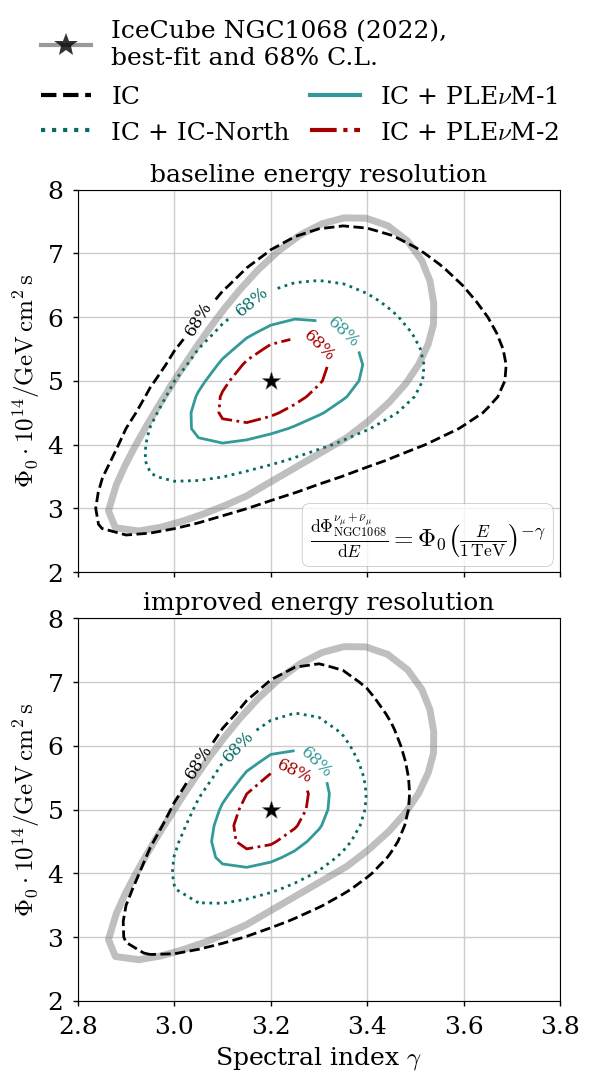

In [69]:
SPL_df = pd.read_pickle(join(LOCALPATH, "ngc_contour_spl.pickle"))
ref_color = "gray"

f, axes = plt.subplots(nrows=2, figsize=(6, 11), sharex=True)

for ii, eres_key in enumerate(energy_reso):
    ax = axes[ii]
    ax.plot(
        gamma_c_68,
        phi_c_68 * 1e11,
        color=ref_color,
        ls="-",
        lw=5,
        alpha=0.5,
    )

    # draw contour levels
    cvals = [0.32]
    lbs = ["68%"]
    levels = chi2.isf(cvals, 2)

    res_local = SPL_df.loc[(SPL_df.LLH == "local") & (SPL_df.energy_res == eres_key)]
    res_global = SPL_df.loc[(SPL_df.LLH == "global") & (SPL_df.energy_res == eres_key)]

    for ident, series in res_local.groupby("ident"):
        local_pivot = series.pivot(
            index="gamma", columns="phi_astro", values="delta_ts"
        )
        sc = ax.contour(
            local_pivot.index,
            local_pivot.columns * ngc_flux.norm * 1e14,
            local_pivot.T,
            levels=levels,
            lw=3,
            **contour_formats[ident],
        )
        fmt = {l: s for l, s in zip(sc.levels, lbs)}
        ax.clabel(sc, levels, fmt=fmt, fontsize=12)
    # best fit
    ax.scatter(
        res_global.gamma.unique(),
        res_global.phi_astro.unique() * ngc_flux.norm * 1e14,
        marker="*",
        s=200,
        color="k",
        edgecolor=ref_color,
    )

    ax.set_ylim(2, 8)
    ax.set_xlim(2.8, 3.8)
    ax.set_ylabel(r"$\Phi_0 \cdot 10^{14} / {\rm GeV\, cm^2\, s}$")
    ax.set_title(f"{eres_key} energy resolution")

ax.set_xlabel(r"Spectral index $\gamma$")

lines = [
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=ref_color,
        ls="-",
        lw=3,
        markersize=18,
        alpha=0.8,
        marker="*",
        mfc="k",
        mec=ref_color,
        label="IceCube NGC1068 (2022),\nbest-fit and 68% C.L.",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["IceCube"]["colors"][0],
        ls=contour_formats["IceCube"]["linestyles"],
        lw=3,
        label="IC",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["P-ONE"]["colors"][0],
        ls=contour_formats["P-ONE"]["linestyles"],
        lw=3,
        label="IC + IC-North",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-1"]["colors"][0],
        ls=contour_formats["Plenum-1"]["linestyles"],
        lw=3,
        label=r"IC + PLE$\nu$M-1",
    ),
    matplotlib.lines.Line2D(
        range(1),
        range(1),
        color=contour_formats["Plenum-2"]["colors"][0],
        ls=contour_formats["Plenum-2"]["linestyles"],
        lw=3,
        label=r"IC + PLE$\nu$M-2",
    ),
]
leg1 = f.legend(
    handles=[
        lines[0],
    ],
    loc="upper left",
    ncol=1,
    bbox_to_anchor=(0.04, 0.99),
    # fontsize="x-large",
    frameon=False,
)
f.legend(
    handles=lines[1:],
    loc="upper left",
    ncol=2,
    bbox_to_anchor=(0.04, 0.93),
    columnspacing=0.8,
    # fontsize="x-large",
    frameon=False,
)
# ax.add_artist(leg1)

flux_str = r"$\frac{{\rm d}\Phi_{\rm NGC 1068}^{\nu_\mu + \bar{\nu}_\mu}}{{\rm d}E}"
flux_str += r"= \Phi_0 \left( \frac{E}{\rm 1\,TeV} \right)^{-\gamma}$"
for ax in axes:
    ax.text(
        0.97,
        0.07,
        flux_str,
        fontsize=18,
        transform=ax.transAxes,
        ha="right",
        bbox=dict(boxstyle="round", facecolor="w", edgecolor="gray", alpha=0.8),
    )
    break
# f.suptitle(f"NGC1068 contour", fontsize="xx-large")
f.tight_layout()
f.subplots_adjust(top=0.815)

f.savefig(join(BASEPATH, "plots/ngc_paper/2D_scan_ngc1068.pdf"))

### Translate contour to flux plot

In [ ]:
## something isn't working anymore here ?! ... not that important, though

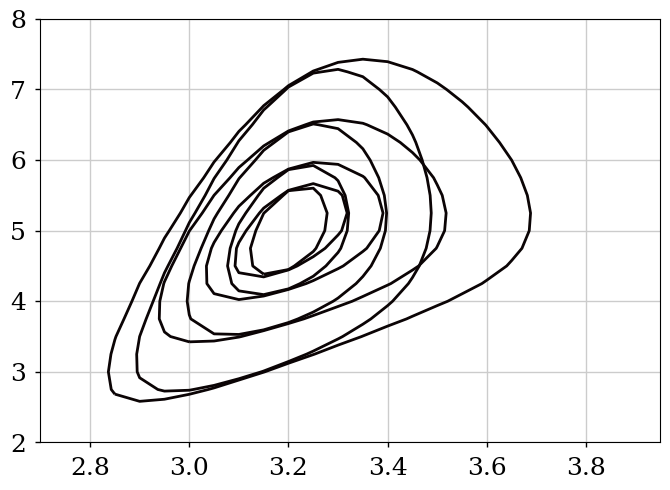

In [ ]:
plenum_ngc_contours = []
for eres_key in energy_reso:
    # draw contour levels
    cvals = [0.32]
    levels = chi2.isf(cvals, 2)

    res_local = SPL_df.loc[(SPL_df.LLH == "local") & (SPL_df.energy_res == eres_key)]
    res_global = SPL_df.loc[(SPL_df.LLH == "global") & (SPL_df.energy_res == eres_key)]

    for ident, series in res_local.groupby("ident"):
        local_pivot = series.pivot(
            index="gamma", columns="phi_astro", values="delta_ts"
        )
        sc = plt.contour(
            local_pivot.index,
            local_pivot.columns * ngc_flux.norm * 1e14,
            local_pivot.T,
            levels=levels,
            lw=3,
        )

        plenum_ngc_contours.append(
            {
                "energy_resolution": eres_key,
                "ident": ident,
                "level": levels[0],
                "contour": sc.allsegs[0][0],
            }
        )
plenum_ngc_contours = pd.DataFrame(plenum_ngc_contours)

In [ ]:
plenum_ngc_contours

,energy_resolution,ident,level,contour
0,baseline,IceCube,2.278869,"[2.8499999999999996, 2.6843095891862037]"
1,baseline,P-ONE,2.278869,"[2.9999999999999996, 3.4248279576337217]"
2,baseline,Plenum-1,2.278869,"[3.049999999999999, 4.1076487417703]"
3,baseline,Plenum-2,2.278869,"[3.0999999999999988, 4.404552475669244]"
4,improved,IceCube,2.278869,"[2.9499999999999993, 2.726964674360606]"
5,improved,P-ONE,2.278869,"[3.049999999999999, 3.5378605269738443]"
6,improved,Plenum-1,2.278869,"[3.0999999999999988, 4.147041037146035]"
7,improved,Plenum-2,2.278869,"[3.1499999999999986, 4.383457664859623]"


In [ ]:
c_low

array([8.07487966e-15, 7.54356807e-15, 7.04721576e-15, 6.58352248e-15,
       6.14557116e-15, 5.73517218e-15, 5.35217950e-15, 4.99476292e-15,
       4.66121449e-15, 4.34994031e-15, 4.05945289e-15, 3.78836413e-15,
       3.53537856e-15, 3.29928729e-15, 3.07896210e-15, 2.87335014e-15,
       2.68085964e-15, 2.49920420e-15, 2.32985775e-15, 2.17198625e-15,
       2.02481214e-15, 1.88761057e-15, 1.75851803e-15, 1.63763815e-15,
       1.52506750e-15, 1.42023492e-15, 1.32251750e-15, 1.23031410e-15,
       1.14453895e-15, 1.06424169e-15, 9.89088415e-16, 9.19242222e-16,
       8.54328338e-16, 7.93998461e-16, 7.37928883e-16, 6.84551449e-16,
       6.33122258e-16, 5.85556855e-16, 5.41564961e-16, 5.00878102e-16,
       4.63247979e-16, 4.28444943e-16, 3.96017810e-16, 3.65880834e-16,
       3.38037283e-16, 3.12312628e-16, 2.88545621e-16, 2.66587284e-16,
       2.46257988e-16, 2.27294109e-16, 2.09790603e-16, 1.93635011e-16,
       1.78723531e-16, 1.64960358e-16, 1.52257061e-16, 1.40532022e-16,
      

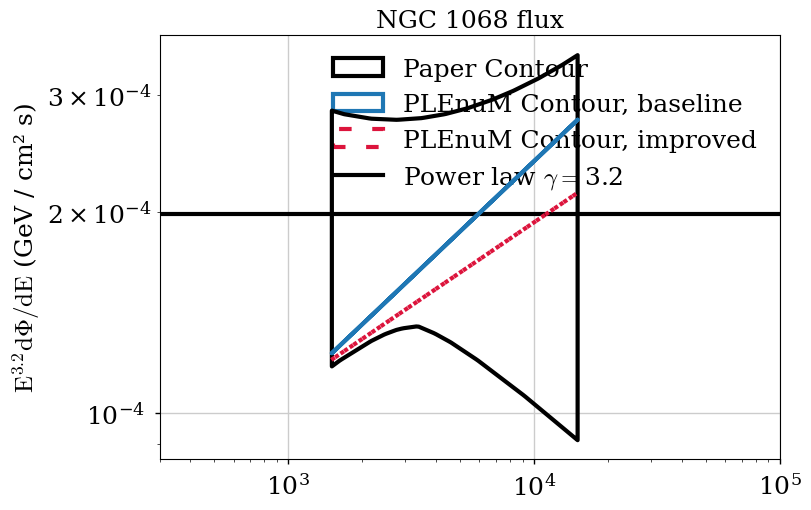

In [ ]:
x_evals = np.logspace(0, 9, 100)
y_scaling = 3.2
f, axx = plt.subplots()

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
# paper reference contour
for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, ngc_flux.E0, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)


axx.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    edgecolor="k",
    facecolor=(0, 0, 0, 0),
    lw=3,
    zorder=15,
    label="Paper Contour",
)

# our contour
for eres_key in energy_reso:
    plenum_contour = plenum_ngc_contours.loc[
        (plenum_ngc_contours.energy_resolution == eres_key)
        & (plenum_ngc_contours.ident == "IceCube")
    ].contour.iloc[0]

    plenum_low = np.zeros_like(x_cont)
    plenum_high = np.zeros_like(x_cont)

    for ii, xe in enumerate(x_cont):
        tmp = power_law(
            xe, ngc_flux.E0, plenum_contour[:, 0], plenum_contour[:, 1] * 1e-14
        )
        plenum_low[ii] = np.min(tmp)
        plenum_high[ii] = np.max(tmp)
    axx.fill_between(
        x_cont,
        plenum_low * (x_cont**y_scaling),
        plenum_high * (x_cont**y_scaling),
        edgecolor="tab:blue" if eres_key == "baseline" else "crimson",
        facecolor=(0, 0, 0, 0),
        lw=3,
        zorder=15,
        ls="-" if eres_key == "baseline" else ":",
        label="PLEnuM Contour, " + eres_key,
    )

# power law flux
pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)
axx.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"Power law $\gamma=${ngc_flux.gamma}",
    color="k",
    alpha=1,
    zorder=10,
    lw=3,
)

# settings
axx.set_title("NGC 1068 flux")
axx.set_yscale("log")
axx.set_ylabel(rf"$\rm E^{{{y_scaling}}} d\Phi / dE$ (GeV / cm² s)")
axx.set_xscale("log")
if y_scaling == 3:
    axx.set_ylim(3e-6, 1e-3)
elif y_scaling == 2:
    axx.set_ylim(1e-11, 1e-5)
axx.set_xlim(3e2, 1e5)
axx.legend(loc=0, frameon=False)
# very nice

## Disc. potential vs dec

In [55]:
# standard
thresholds = [sigma5]
detector_keys = [
    "IceCube" ,
    "P-ONE" ,
    "Plenum-1",
    "Plenum-2",
]
decs = np.arange(-90, 91, step=5)

tmp = []  # save output here
for ident in detector_keys:
    conf = st.detector_configurations[ident]
    
    for dec in tqdm(np.deg2rad(decs)):
        if "IceCube" in ident and dec < np.deg2rad(-5):
            # skip the Southern Hemisphere
            continue

        # insert the declination into the configs
        cur_bg_conf = bg_config.copy()
        cur_bg_conf["dec"] = dec

        cur_sig_conf = src_config.copy()
        cur_sig_conf["dec"] = dec

        # set up all ingredients for the multi-sample likelihood calculation
        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
            all_k_b,
            all_k_s,
        ) = setup_multi_llh(
            energy_reso["improved"],  # select one resolution for all data sets
            conf,
            aeff_2d=aeff_2d,
            bckg_histo=bckg_histo,
            bg_config=cur_bg_conf,
            sig_config=cur_sig_conf,
            return_s_b=True,
            src_flux=ngc_flux
        )
        # calculate an estimate for the flux scaling
        scaler = 4 / (np.sum(all_k_s) / np.sqrt(np.sum(all_k_b)))
        current_thresholds = copy(thresholds)
        count = 0

        # calculate the significance with various flux scalings to obtain
        # the 5-sigma discovery threshold by interpolation
        while len(current_thresholds) > 0:
            # scale the number of signal events - equivalent to scaling the flux
            current_k_s = [ks * scaler for ks in all_k_s]
            current_k_i = [ks + kb for ks, kb in zip(current_k_s, all_k_b)]

            dct = dict(
                shape="powerlaw",
                all_aeff_factor_s=all_aeff_factor_s,
                all_aeff_factor_b=all_aeff_factor_b,
                all_k=current_k_i,
                all_bckg_flux=all_bckg_flux,
                all_eres=all_eres,
                e_0=ngc_flux.E0,
                phi_0=ngc_flux.norm,
            )
            # fix signal contribution to 0 for background fit
            local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
            global_llh = lambda x: ps_llh_multi(x, **dct)

            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1,),
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1, 1, ngc_flux.gamma),
                approx_grad=True,
            )

            tmp_dct = {
                "ident": ident,
                "dec": dec,
                "scaler": scaler,
                "cur_thresh": current_thresholds[0],
                "SosB": np.sum(current_k_s) / np.sqrt(np.sum(all_k_b)),
                "n_b": np.sum(all_k_b),
                "n_sig": np.sum(current_k_s),
                "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 2)),
            }
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask], current_thresholds, scaler, stop_here=0.2
            )

            if scaler == -1:
                break

df = pd.DataFrame(tmp)
df.to_pickle(join(LOCALPATH, "ngc_disc_pot.pickle"))

  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████| 37/37 [00:41<00:00,  1.11s/it]


In [49]:
df = pd.read_pickle(join(LOCALPATH, "ngc_disc_pot.pickle"))
flux = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma5)) * PHI_NGC,
    columns=["disc5"],
).reset_index()
flux["dec_deg"] = np.rad2deg(flux.dec)

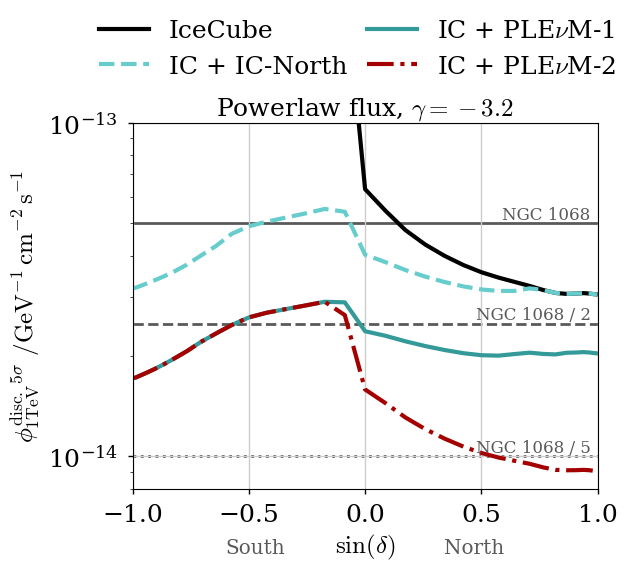

In [66]:
f, ax = plt.subplots(figsize=(6, 6))
for ident, series in flux.groupby("ident"):
    plt.plot(
        np.sin(series.dec),
        series.disc5,
        lw=3,
        **{k: det_plotting[ident][k] for k in ["ls", "color", "label"]},
    )
ax.set_yscale("log")
ax.set_xlabel(r"$\sin(\delta)$")
ax.set_ylabel(
    r"$\phi^{\mathrm{disc.~5\sigma}}_{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$"
)
f.legend(
    loc="upper center",
    frameon=False,
    # fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)
ax.set_ylim(8e-15, 1e-13)
ax.set_xlim(-1, 1)
font_color = "0.35"
for ii, _ls in zip([1, 2, 5], ["-", "--", ":"]):
    ax.axhline(ngc_flux.norm / ii, ls=_ls, lw=2, color=font_color, zorder=0)
    ax.text(
        x=0.97,
        y=ngc_flux.norm / ii,
        va="bottom",
        s="NGC 1068" if ii == 1 else f"NGC 1068 / {ii}",
        color=font_color,
        fontsize="large", ha="right"
    )
ax.text(0.2, -0.175, "South", fontsize="x-large", color=font_color, transform=ax.transAxes)
ax.text(0.8, -0.175, "North", ha="right", fontsize="x-large", color=font_color, transform=ax.transAxes)

f.subplots_adjust(top=0.72)
ax.set_title(r"Powerlaw flux, $\gamma=-3.2$")

f.savefig(join(BASEPATH, "plots/ngc_paper/ngc_disc_pot.pdf"), bbox_inches="tight")

# Power law vs. Power-law with cutoff
## normal vs. improved E resolution

In [32]:
idents = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
detector_conf = [{"key": k, "identifier": det_plotting[k]["label"]} for k in idents]

eres_conf = (
    {"e_file": e_res_files["baseline"], "e_name": "Baseline"},
    {"e_file": e_res_files["1:1"], "e_name": "Removed bias"},
    #{"e_file": e_res_files["improved-20"], "e_name": "20% improv."},
    {"e_file": e_res_files["improved-50"], "e_name": "50% improv."},
)
# livetime relative to 10yrs

eres_detector_configurations = []
for dc, eresc in product(detector_conf, eres_conf):
    eres_detector_configurations.append(dc | eresc)
eres_detector_configurations = pd.DataFrame(eres_detector_configurations)

eres_detector_configurations

,key,identifier,e_file,e_name
0,IceCube,IceCube,/home/hpc/capn/capn102h/repos/Plenum/local/ene...,Baseline
1,IceCube,IceCube,/home/hpc/capn/capn102h/repos/Plenum/local/ide...,Removed bias
2,IceCube,IceCube,/home/hpc/capn/capn102h/repos/Plenum/local/imp...,50% improv.
3,P-ONE,IC + IC-North,/home/hpc/capn/capn102h/repos/Plenum/local/ene...,Baseline
4,P-ONE,IC + IC-North,/home/hpc/capn/capn102h/repos/Plenum/local/ide...,Removed bias
5,P-ONE,IC + IC-North,/home/hpc/capn/capn102h/repos/Plenum/local/imp...,50% improv.
6,Plenum-1,IC + PLE$\nu$M-1,/home/hpc/capn/capn102h/repos/Plenum/local/ene...,Baseline
7,Plenum-1,IC + PLE$\nu$M-1,/home/hpc/capn/capn102h/repos/Plenum/local/ide...,Removed bias
8,Plenum-1,IC + PLE$\nu$M-1,/home/hpc/capn/capn102h/repos/Plenum/local/imp...,50% improv.
9,Plenum-2,IC + PLE$\nu$M-2,/home/hpc/capn/capn102h/repos/Plenum/local/ene...,Baseline


### Significance

In [33]:
pvals_ngc = []
for (identifier, es_ident), series in eres_detector_configurations.groupby(
    ["identifier", "e_name"], sort=False
):
    conf = st.detector_configurations[series.key.iloc[0]]
    print("info:", identifier, conf, es_ident)
    print(series.e_file.iloc[0])
    # energy smearing matrix
    with open(series.e_file.iloc[0], "rb") as f:
        eres = pickle.load(f)
    eres.normalize(axis=1)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        eres,  # select one resolution for all data sets
        conf,
        aeff_2d=aeff_2d,
        bckg_histo=bckg_histo,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config,
        src_flux= ngc_cut_flux
    )

    dct = dict(
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_cut_flux.E0,
        phi_0=ngc_cut_flux.norm,
    )
    pl_func = lambda x: ps_llh_multi(x, shape="powerlaw", **dct)
    out_bckg = fmin_l_bfgs_b(
        pl_func,
        x0=(1.2, 1.2, 3.0),
        approx_grad=True,
    )
    print("bckg params:", out_bckg[0])

    comp = lambda x: ps_llh_multi(x, shape="powerlaw with cutoff", **dct)
    out_comp = fmin_l_bfgs_b(
        comp,
        x0=(1.2, 1.1, 1.9, 3.4),
        approx_grad=True,
    )
    print("global params:", out_comp[0])
    print("true params:", (1, 1, st.Gamma_cut, st.logE_cut))

    # check the LLH at the "correct" parameter position
    check = comp((1, 1, st.Gamma_cut, st.logE_cut))
    pval = chi2.sf(out_bckg[1] - out_comp[1], 1)
    pval_check = chi2.sf(out_bckg[1] - check, 1)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print("pval check:", pval_check, "ratio:", pval_check / pval)
    print("")
    pvals_ngc.append(
        {
            "identifier": identifier,
            "key": series.key.iloc[0],
            "e_smearing": es_ident,
            "pval": pval,
            r"Significance in $\sigma$": significance,
        }
    )
pvals_ngc = pd.DataFrame(pvals_ngc)
pvals_ngc.to_pickle(join(LOCALPATH, "ngc_performance_cut_eres.pickle"))

info: IceCube (['IceCube'], [1]) Baseline
/home/hpc/capn/capn102h/repos/Plenum/local/energy_smearing_GP_up.pckl
bckg params: [0.99255983 0.77103307 3.24763622]
global params: [0.99926363 1.104231   1.89045163 3.4272785 ]
true params: (1, 1, 2.0, 3.5)
P-VALUE: 0.34626440557779925 SIGNIFICANCE: 0.39542561089458395
pval check: 0.3435626181481981 ratio: 0.9921973284401185

info: IceCube (['IceCube'], [1]) Removed bias
/home/hpc/capn/capn102h/repos/Plenum/local/idealized_artificial_energy_smearing_GP_up.pckl
bckg params: [0.9967853  0.69473112 3.08189617]
global params: [0.99931614 1.10076561 1.88876095 3.42871942]
true params: (1, 1, 2.0, 3.5)
P-VALUE: 0.04712155804961388 SIGNIFICANCE: 1.6734277634372934
pval check: 0.0462528122436883 ratio: 0.9815637291744282

info: IceCube (['IceCube'], [1]) 50% improv.
/home/hpc/capn/capn102h/repos/Plenum/local/improved_0.5_artificial_energy_smearing_GP_up.pckl
bckg params: [0.9968658  0.69247247 3.07677972]
global params: [0.99935003 1.10076593 1.88893

### Nice significance summary plot

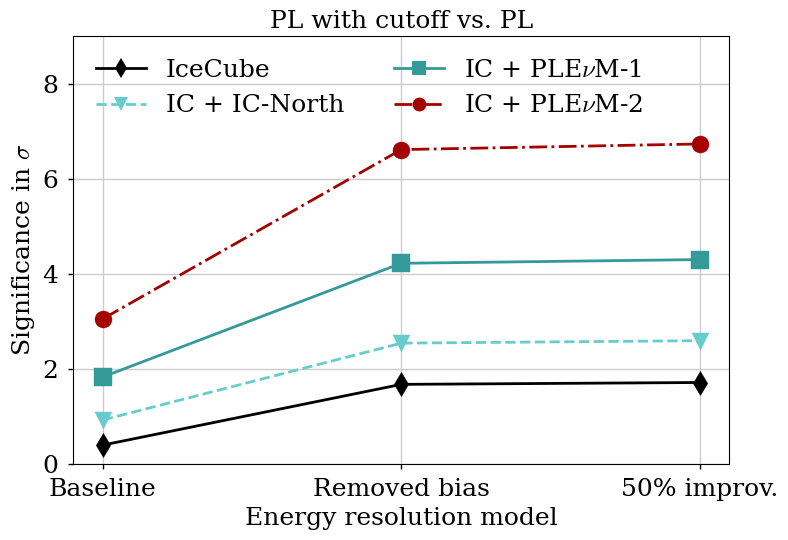

In [34]:
pval_df = pd.read_pickle(join(LOCALPATH, "ngc_performance_cut_eres.pickle"))
f, ax = plt.subplots()
for ident, series in pval_df.groupby("key"):
    series
    ax.plot(
        series["e_smearing"],
        series[r"Significance in $\sigma$"],
        ls=det_plotting[ident]["ls"],
        color=det_plotting[ident]["color"],
        marker=det_plotting[ident]["marker"],
        label=series.identifier.iloc[0],
        ms=10,
    )
    ax.scatter(
        x=series["e_smearing"],
        y=series[r"Significance in $\sigma$"],
        c=[det_plotting[ident]["color"]],
        s=150,
        zorder=10,
        marker=det_plotting[ident]["marker"],
    )

ax.set_ylim(0, 9)
ax.legend(loc=2, ncol=2, frameon=False)  # , fontsize="large")
ax.set_title("PL with cutoff vs. PL")  # , fontsize=18)
ax.set_xlabel("Energy resolution model")  # , fontsize=18)
ax.set_ylabel(r"Significance in $\sigma$")  # , fontsize=18)
f.tight_layout()
f.savefig(join(BASEPATH, "plots/ngc_paper/cutoff_sigma_vs_eres_ngc.pdf"))

In [36]:
pval_df.loc[pval_df.e_smearing=="Baseline"]

,identifier,key,e_smearing,pval,Significance in $\sigma$
0,IceCube,IceCube,Baseline,0.346264,0.395426
3,IC + IC-North,P-ONE,Baseline,0.177772,0.923889
6,IC + PLE$\nu$M-1,Plenum-1,Baseline,0.033625,1.830003
9,IC + PLE$\nu$M-2,Plenum-2,Baseline,0.001131,3.053377


## spectral fit vs. dec

scan for right threshold

In [41]:
detector_keys = ["IceCube", "P-ONE", "Plenum-1", "Plenum-2"]
decs = np.arange(-90, 91, step=5)
num = 20

thresholds = [sigma3, 0.01, 0.1]
tmp = []
for ident in detector_keys:
    conf = st.detector_configurations[ident]

    for dec in tqdm(np.deg2rad(decs)):
        if ident == "IceCube" and dec < np.deg2rad(-5):
            # skip the Southern Hemisphere
            continue

        # insert the declination into the configs
        cur_bg_conf = bg_config.copy()
        cur_bg_conf["dec"] = dec

        cur_sig_conf = src_config.copy()
        cur_sig_conf["dec"] = dec

        # set up all ingredients for the multi-sample likelihood calculation
        (
            all_aeff_factor_s,
            all_aeff_factor_b,
            all_k,
            all_bckg_flux,
            all_eres,
            all_k_b,
            all_k_s,
        ) = setup_multi_llh(
            energy_reso["improved"],  # select one resolution for all data sets
            conf,
            aeff_2d=aeff_2d,
            bckg_histo=bckg_histo,
            bg_config=cur_bg_conf,
            sig_config=cur_sig_conf,
            return_s_b=True,
            src_flux=ngc_cut_flux,
        )

        # calculate an estimate for the flux scaling
        scaler = 8 / (np.sum(all_k_s) / np.sqrt(np.sum(all_k_b)))
        current_thresholds = copy(thresholds)

        while len(current_thresholds) > 0:
            # scale the number of signal events - equivalent to scaling the flux
            current_k_s = [ks * scaler for ks in all_k_s]
            current_k_i = [ks + kb for ks, kb in zip(current_k_s, all_k_b)]

            dct = dict(
                all_aeff_factor_s=all_aeff_factor_s,
                all_aeff_factor_b=all_aeff_factor_b,
                all_k=current_k_i,
                all_bckg_flux=all_bckg_flux,
                all_eres=all_eres,
                e_0=ngc_cut_flux.E0,
                phi_0=ngc_cut_flux.norm,
            )

            # fix signal contribution to powerlaw
            local_llh = lambda x: ps_llh_multi(x, shape="powerlaw", **dct)
            global_llh = lambda x: ps_llh_multi(x, shape="powerlaw with cutoff", **dct)
            out_bckg = fmin_l_bfgs_b(
                local_llh,
                x0=(1.2, 1.2, GAMMA_NGC),
                bounds=[(0, 10), (0, 10), (1, 5)],
                approx_grad=True,
            )

            out_comp = fmin_l_bfgs_b(
                global_llh,
                x0=(1.2, scaler, st.Gamma_cut, st.logE_cut),
                approx_grad=True,
            )
            tmp_dct = {
                "ident": ident,
                "dec": dec,
                "scaler": scaler,
                "cur_thresh": current_thresholds[0],
                "SosB": np.sum(current_k_s) / np.sqrt(np.sum(all_k_b)),
                "n_sig": np.sum(current_k_s),
                "out_bg": out_bckg,
                "out_comp": out_comp,
                "log10(p)": -np.log10(chi2.sf(out_bckg[1] - out_comp[1], 1)),
            }
            tmp.append(tmp_dct)
            tmp_df = pd.DataFrame(tmp)
            mask = (
                (tmp_df.dec == dec)
                & (tmp_df.ident == ident)
                & (tmp_df.cur_thresh == current_thresholds[0])
            )
            scaler = scaling_estimation(
                tmp_df.loc[mask],
                current_thresholds,
                scaler,
                stop_here=0.2,
                stepper=2,
                min_steps=1,
            )

            if scaler == -1:
                break

df = pd.DataFrame(tmp)
df.to_pickle(join(LOCALPATH, "ngc_spectral_disc_pot.pickle"))

  0%|          | 0/37 [00:00<?, ?it/s]

100%|██████████| 37/37 [03:23<00:00,  5.51s/it]


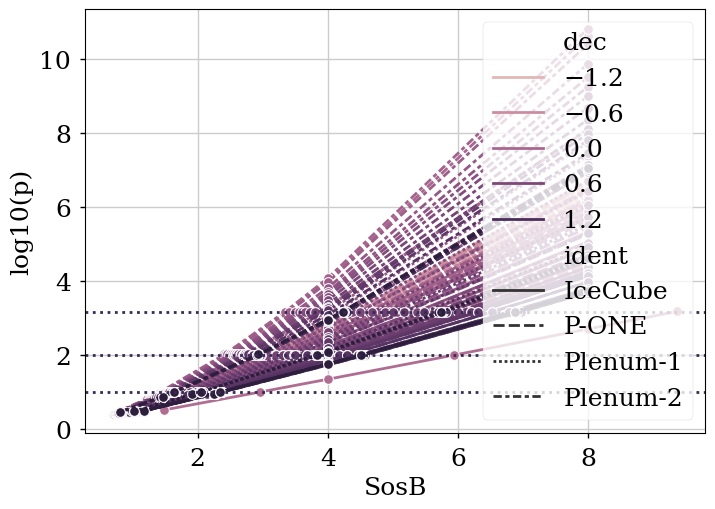

In [42]:
thresholds = [sigma3, 0.01, 0.1]
xname = "SosB"  # "scaler" #
ax = sns.lineplot(data=df, y="log10(p)", x=xname, marker="o", hue="dec", style="ident")
for t in thresholds:
    plt.axhline(-np.log10(t), ls=":")
plt.legend()

## plotting


In [60]:
df = pd.read_pickle(join(LOCALPATH, "ngc_spectral_disc_pot.pickle"))
flux = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma3))
    * ngc_cut_flux.norm,
    columns=["sigma3"],
)
flux["1%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.01))
    * ngc_cut_flux.norm
)
flux["5%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.05))
    * ngc_cut_flux.norm
)
flux["10%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.1)) * ngc_cut_flux.norm
)
flux = flux.reset_index()


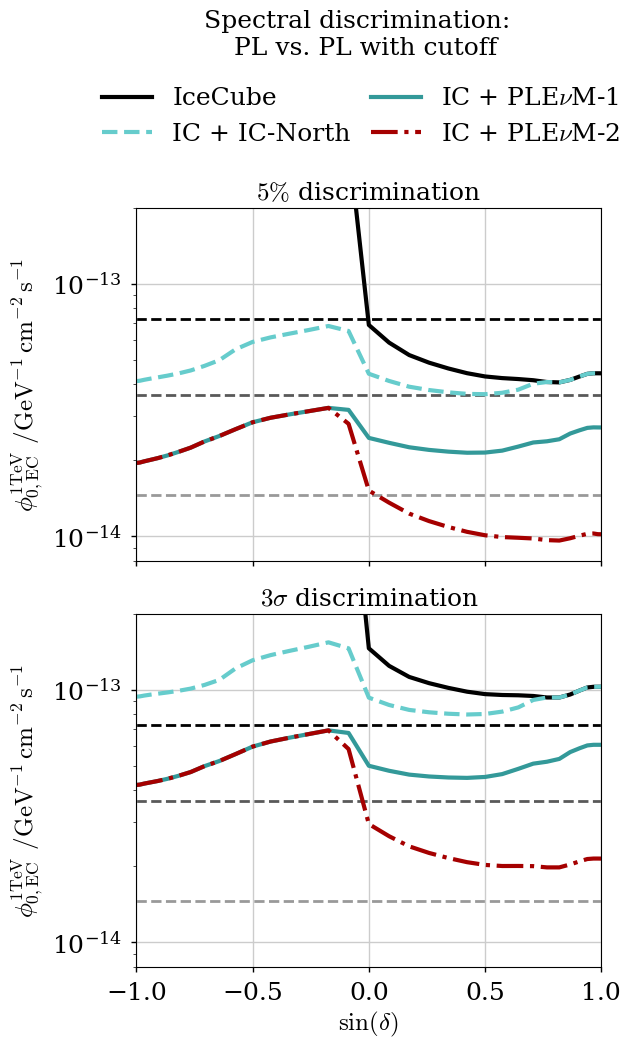

In [45]:

# we use ngc_cut_flux as baseline,
# such that the best-fit scaler needs to be multiplied to ngc_cut_flux.norm

### plot various thresholds
f, axes = plt.subplots(nrows=2, figsize=(6, 11), sharex=True)
for ident, series in flux.groupby("ident"):
    axes[1].plot(
        np.sin(series.dec),
        series.sigma3,
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "ls"]}
    )
    axes[0].plot(
        np.sin(series.dec),
        series["5%"],
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "label", "ls"]}
    )
for ax in axes:
    ax.set_yscale("log")
    ax.axhline(ngc_cut_flux.norm, ls="--", lw=2, color="k", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 2, ls="--", lw=2, color="0.35", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 5, ls="--", lw=2, color="0.6", zorder=0)
    ax.set_xlim(-1, 1)
    ax.set_ylabel(
        r"$\phi_{0, \rm EC}^{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$",
        fontsize=18,
    )
    ax.set_ylim(8e-15, 2e-13)

f.legend(
    loc="upper center",
    frameon=False,
    # fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.5, 0.93),
    columnspacing=0.8,
)
axes[0].set_title(r"$5\%$ discrimination", fontsize=18)
axes[1].set_title(r"$3 \sigma$ discrimination", fontsize=18)
axes[1].set_xlabel(r"$\sin(\delta)$", fontsize=18)
f.subplots_adjust(hspace=0.15, top=0.8)
f.suptitle("Spectral discrimination: \n PL vs. PL with cutoff", fontsize=18)
f.savefig(
    join(BASEPATH, "plots/ngc_paper/ngc_spectral_disc_pot.pdf"), bbox_inches="tight"
)

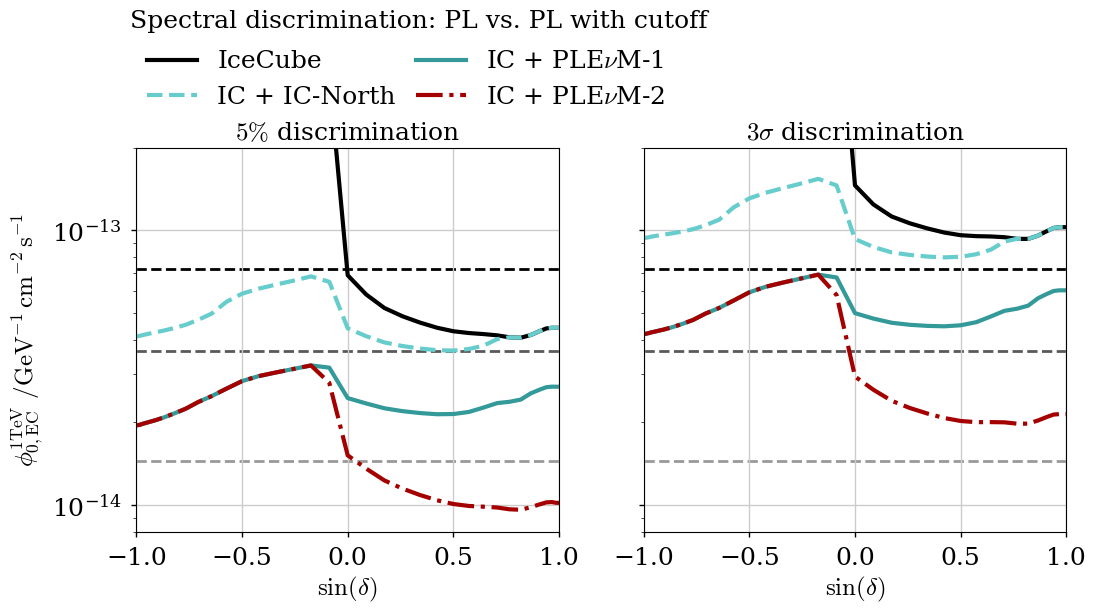

In [46]:
df = pd.read_pickle(join(LOCALPATH, "ngc_spectral_disc_pot.pickle"))
flux = pd.DataFrame(
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, sigma3))
    * ngc_cut_flux.norm,
    columns=["sigma3"],
)
flux["1%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.01))
    * ngc_cut_flux.norm
)
flux["5%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.05))
    * ngc_cut_flux.norm
)
flux["10%"] = (
    df.groupby(["ident", "dec"]).apply(lambda x: get_scaler(x, 0.1)) * ngc_cut_flux.norm
)
flux = flux.reset_index()

# we use ngc_cut_flux as baseline,
# such that the best-fit scaler needs to be multiplied to ngc_cut_flux.norm

### plot various thresholds
f, axes = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
for ident, series in flux.groupby("ident"):
    axes[1].plot(
        np.sin(series.dec),
        series.sigma3,
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "ls"]}
    )
    axes[0].plot(
        np.sin(series.dec),
        series["5%"],
        lw=3,
        **{k: det_plotting[ident][k] for k in ["color", "label", "ls"]}
    )
for ax in axes:
    ax.set_yscale("log")
    ax.axhline(ngc_cut_flux.norm, ls="--", lw=2, color="k", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 2, ls="--", lw=2, color="0.35", zorder=0)
    ax.axhline(ngc_cut_flux.norm / 5, ls="--", lw=2, color="0.6", zorder=0)
    ax.set_xlim(-1, 1)
    ax.set_xlabel(r"$\sin(\delta)$", fontsize=18)
    ax.set_ylim(8e-15, 2e-13)

f.legend(
    loc="upper center",
    frameon=False,
    # fontsize=14,
    ncol=2,
    bbox_to_anchor=(0.35, 0.95),
    columnspacing=0.8,
)
axes[0].set_title(r"$5\%$ discrimination", fontsize=18)
axes[1].set_title(r"$3 \sigma$ discrimination", fontsize=18)
axes[0].set_ylabel(
    r"$\phi_{0, \rm EC}^{1\rm TeV} ~ / \rm GeV^{-1} \, cm^{-2} \, s^{-1}$",
    fontsize=18,
)
f.subplots_adjust(hspace=0.15, top=0.75)
f.suptitle("Spectral discrimination: PL vs. PL with cutoff", fontsize=18, ha="left", x=0.12)
f.savefig(
    join(BASEPATH, "plots/ngc_paper/ngc_spectral_disc_pot_horizontal.pdf"),
    bbox_inches="tight",
)

# Model fit Inoue et al 2023 ICRC
https://pos.sissa.it/444/1161/pdf 

In [64]:
# unit conversion
import astropy.units as u

E = 1 * u.erg
erg_to_GeV = E.to(u.GeV).value

print(erg_to_GeV)

inoue_data = pd.read_csv(
    "/home/hpc/capn/capn102h/repos/Plenum/local/neutrino_models/inoue_icrc2023.txt",
    skipinitialspace=True,
)
inoue_data["E_GeV"] = 10 ** (inoue_data["logE_eV"] - 9)
inoue_data["flux"] = (
    (10 ** inoue_data["E2_flux_erg"])
    * 1e3  # it should be erg_to_GeV =~ 624, but it seems like it's just 1E3 in the plot ... (?!)
    / (inoue_data["E_GeV"] ** 2)
)
model_flux = namedtuple("model_flux", "norm model_spline shape")
inoue_src_flux = model_flux(
    1,
    InterpolatedUnivariateSpline(
        np.log10(inoue_data["E_GeV"]), np.log10(inoue_data["flux"]), k=1
    ),
    "model_flux",
)

624.1509074460764


In [74]:
np.log10(np.e) * np.log(10)

0.9999999999999999

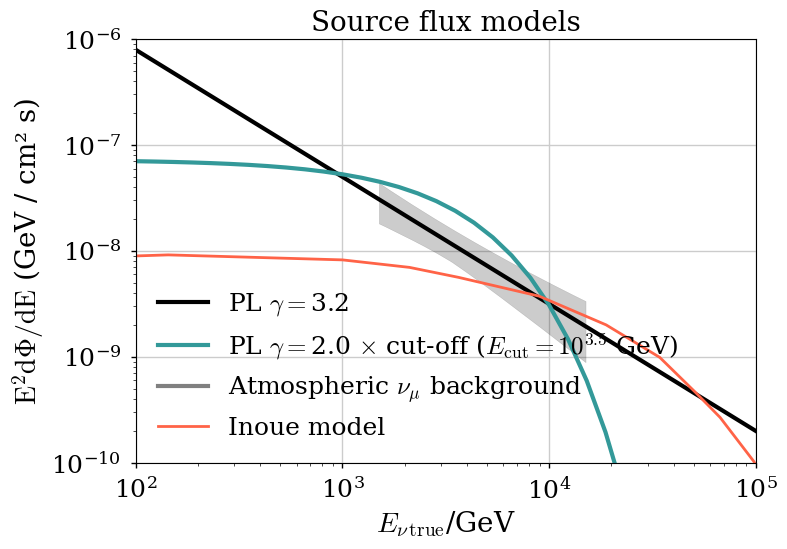

In [71]:
sq_deg = np.pi * st.delta_psi_max**2
x_evals = np.logspace(0, 9, 100)
y_scaling = 2

pl = power_law(x_evals, ngc_flux.E0, ngc_flux.gamma, ngc_flux.norm)
cut = power_law(
    x_evals, ngc_cut_flux.E0, ngc_cut_flux.gamma, ngc_cut_flux.norm
) * cut_off(x_evals, 10**ngc_cut_flux.e_cut)

f, ax = plt.subplots()
fontsize = 20
ax.set_title("Source flux models", fontsize=fontsize)

# error contour
# with energy range interval
x_cont = np.logspace(np.log10(1.5e3), np.log10(1.5e4), 100)
# without energy range interval
# x_cont = np.logspace(1.9, 5.1, 100)
c_low = np.zeros_like(x_cont)
c_high = np.zeros_like(x_cont)
for ii, xe in enumerate(x_cont):
    tmp = power_law(xe, E0_NGC, gamma_c_68, phi_c_68 / 1e3)
    c_low[ii] = np.min(tmp)
    c_high[ii] = np.max(tmp)
ax.fill_between(
    x_cont,
    c_low * (x_cont**y_scaling),
    c_high * (x_cont**y_scaling),
    color="k",
    alpha=0.2,
)

ax.plot(
    x_evals,
    pl * (x_evals**y_scaling),
    label=rf"PL $\gamma=${GAMMA_NGC}",
    color="k",
    alpha=1,
    lw=3,
)

ax.plot(
    x_evals,
    cut * (x_evals**y_scaling),
    label=rf"PL $\gamma=${st.Gamma_cut} $\times$ "
    + rf"cut-off ($E_{{\rm cut}}=10^{{{st.logE_cut:1.1f}}}$ GeV)",
    color="#339999",
    lw=3,
)
ax.plot(
    10 ** aeff_factor_signal.bin_mids[1],
    array_source_interp(
        ngc_src_config["dec"],
        bckg_histo["IceCube"],
        bckg_histo["IceCube"].bin_mids[0],
        axis=1,
    )
    * sq_deg
    * (10 ** aeff_factor_signal.bin_mids[1] ** y_scaling),
    label=r"Atmospheric $\nu_\mu$ background",
    color="gray",
    lw=3,
)

ax.set_yscale("log")
ax.set_ylabel(r"$\rm E^2 d\Phi / dE$ (GeV / cm² s)", fontsize=fontsize)
ax.set_xscale("log")
ax.set_xlabel(r"$E_{\nu \, \rm true}$/GeV", fontsize=fontsize)
ax.set_ylim(1e-10, 1e-6)
ax.set_xlim(1e2, 1e5)



ax.plot(
    inoue_data["E_GeV"],
    inoue_data["flux"] * inoue_data["E_GeV"] ** 2,
    color="tomato",
    label="Inoue model",
)

ax.legend(frameon=False, loc=0)

### event numbers

In [ ]:
aeff_factor_signal = calc_aeff_factor(aeff_2d["IceCube"], **ngc_src_config)
k_s = astro_flux(
    aeff_factor=aeff_factor_signal,
    emids=10 ** aeff_factor_signal.bin_mids[1],
    energy_resolution=baseline_eres,
    phi_scaling=1,
    flux_shape=inoue_src_flux,  # powerlaw
)

In [ ]:
np.sum(k_s)

27.424176894957608

In [ ]:
## powerlaw fit of inoue model
detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]
for key in detector_keys:
    conf = st.detector_configurations[key]
    print(key)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        baseline_eres,
        conf,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config,
        src_flux=inoue_src_flux
    )

    dct = dict(
        shape="powerlaw",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_flux.E0,
        phi_0=ngc_flux.norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_flux.gamma),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("TS check:", global_llh((1, 1, ngc_flux.gamma)), "(fit: ", out_comp[1], ")")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

IceCube
Atmo-only normalization: [1.02283864]
Signal fit parameters: [0.99599299 0.30305042 2.86264914]
TS check: -333803.3296563681 (fit:  -333811.7090702143 )
-2 Delta LLH: 5.929911215906031
P-VALUE: 0.05156275817069213 SIGNIFICANCE: 1.6298863630222986

Plenum-1
Atmo-only normalization: [1.02823825]
Signal fit parameters: [0.99575737 0.27433661 2.81368065]
TS check: -1482494.5390236888 (fit:  -1482543.9200495363 )
-2 Delta LLH: 29.26954074855894
P-VALUE: 4.407577755107703e-07 SIGNIFICANCE: 4.916396974669027

Plenum-2
Atmo-only normalization: [1.02459006]
Signal fit parameters: [0.99606591 0.28971822 2.84173143]
TS check: -1440441.0909819885 (fit:  -1440544.879013715 )
-2 Delta LLH: 67.82696900749579
P-VALUE: 1.868791361512559e-15 SIGNIFICANCE: 7.863428986766314



In [ ]:
## powerlaw x cutoff fit of inoue model

detector_keys = ["IceCube", "Plenum-1", "Plenum-2"]
for key in detector_keys:
    conf = st.detector_configurations[key]
    print(key)

    (
        all_aeff_factor_s,
        all_aeff_factor_b,
        all_k,
        all_bckg_flux,
        all_eres,
    ) = setup_multi_llh(
        baseline_eres,
        conf,
        bg_config=ngc_bg_config,
        sig_config=ngc_src_config,
        src_flux=inoue_src_flux
    )

    dct = dict(
        shape="powerlaw with cutoff",
        all_aeff_factor_s=all_aeff_factor_s,
        all_aeff_factor_b=all_aeff_factor_b,
        all_k=all_k,
        all_bckg_flux=all_bckg_flux,
        all_eres=all_eres,
        e_0=ngc_cut_flux.E0,
        phi_0=ngc_cut_flux.norm,
    )

    # fix signal normalization to 0
    local_llh = lambda x: ps_llh_multi((x[0], 0, 2, 3), **dct)
    global_llh = lambda x: ps_llh_multi(x, **dct)

    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1,),
        approx_grad=True,
    )
    print("Atmo-only normalization:", out_bckg[0])

    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1, 1, ngc_cut_flux.gamma, ngc_cut_flux.e_cut),
        approx_grad=True,
    )
    print("Signal fit parameters:", out_comp[0])
    print("TS check:", global_llh((1, 1, ngc_cut_flux.gamma, ngc_cut_flux.e_cut)), "(fit: ", out_comp[1], ")")
    print("-2 Delta LLH:", out_bckg[1] - out_comp[1])

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = norm.isf(pval)
    print("P-VALUE:", pval, "SIGNIFICANCE:", significance)
    print()

IceCube
Atmo-only normalization: [1.02283864]
Signal fit parameters: [1.00297351 0.02251359 1.10174637 3.86450213]
TS check: -333800.90639825934 (fit:  -333811.9302865518 )
-2 Delta LLH: 6.151127553428523
P-VALUE: 0.04616359508393119 SIGNIFICANCE: 1.6832474938767505

Plenum-1
Atmo-only normalization: [1.02823825]
Signal fit parameters: [1.00376516 0.02256867 1.00844729 3.81253161]
TS check: -1482486.8064779514 (fit:  -1482544.7219611641 )
-2 Delta LLH: 30.071452376432717
P-VALUE: 2.9516651323177465e-07 SIGNIFICANCE: 4.99435310798456

Plenum-2
Atmo-only normalization: [1.02459006]
Signal fit parameters: [1.00321168 0.02216131 1.05421418 3.84152332]
TS check: -1440417.6072585443 (fit:  -1440547.1591238687 )
-2 Delta LLH: 70.10707916109823
P-VALUE: 5.976421080956418e-16 SIGNIFICANCE: 8.004936411017598



# Further Checks